# AHRS: Euler angle based Extended Kalman Filter 

- Prediction
    * Gyroscope 출력을 사용하여 변환한 Euler angular rate와 이전 state의 Euler angle을 이용하여 prediction을 수행    
- Update
    * Measurement로 쓰이는 Roll과 Pitch angle은 가속도계 출력을 사용하여 구한다.
    * Measurement로 쓰이는 Yaw angle은 Magnetometer의 출력을 사용하여 구한다.
- State variable
$$
x=
\begin{bmatrix}
\phi\\
\theta\\
\psi\\
\end{bmatrix}
$$

- Measurement
$$
z=
\begin{bmatrix}
\phi\\
\theta\\
\psi\\
\end{bmatrix}
$$


#### 3.1.2 Prediction
- Prediction을 위한 첫 번째 단계는 body에 장착된 gyroscope의 angular rate 측정 $m=[p, q, r]^T$을 Euler angular reta $x'(x,m)$로 변환하는 것이다.
- 이러한 변환은 다음과 같으며, 변환을 위해서는 Euler angle($x =[\phi, \theta, \psi]^T$) 에 대한 사전 정보가 필요하다.

$$
\begin{aligned}
x'(x,m)=
\begin{bmatrix}
\dot \phi\\
\dot \theta\\
\dot \psi\\
\end{bmatrix}
&=
\begin{bmatrix}
1&\sin \phi \tan \theta& \cos \phi \tan \ \theta\\
0& \cos\phi& -\sin\phi\\
0&\sin\phi/\cos\theta&\cos\phi/\cos\theta
\end{bmatrix}
\begin{bmatrix}
p\\
q\\
r\\
\end{bmatrix}
+w\\
&=
\begin{bmatrix}
p+q\sin\phi \tan\theta+r\cos\phi \tan\theta\\
q \cos\phi -r\sin\phi\\
q \sin\phi \sec\theta + r\cos\phi \sec\theta
\end{bmatrix}
+w
\end{aligned}
$$

- Euler angle은 Euler angular rate $x'$를 시간단위로 누적함으로써 구할 수 있다.
- Euler angle을 discrete time system equation으로 나타내면,
    * 이전 시간의 Euler angle $x_{t-1}$에 현재 시점에 구한 Euler angle을 누적하는 것으로 나타낼 수 있다.
    * 여기서 현재 시점의 Euler angle은 gyroscope의 출력을 사용하여 구한 Euler angular rate $x'(x_{t-1}, m_t)$에 샘플 주기 $T_s$를 곱해서 구할 수 있다.
- Discrete time system equation은 다음과 같이 나태낼 수 있다.

$$
\begin{aligned}
x_{t} &= (x_{t-1} +x'(x_{t-1},m_t) T_s)\\
&=
\begin{bmatrix}
\phi\\
\theta\\
\psi
\end{bmatrix}
+
\begin{bmatrix}
p+q\sin\phi \tan\theta+r\cos\phi \tan\theta\\
q \cos\phi -r \sin\phi\\
q \sin\phi \sec\theta + r \cos\phi \sec\theta\\
\end{bmatrix}
T_s+w_tTs\\
&=
\begin{bmatrix}
(p+q\sin\phi \tan\theta+r\cos\phi \tan\theta)T_s + \phi\\
(q \cos\phi -r \sin\phi)T_s + \theta\\
(q \sin\phi \sec\theta + r \cos\phi \sec\theta)T_s + \psi
\end{bmatrix}
+w_tT_s\\
&= g(x_{t-1}, m_t, T_s) + w_tT_s\\
&\approx g(x_{t-1}, m_t, T_s) + w_t\\
\end{aligned}
$$

- System equation에 의해 구해진 Euler angle $x_t$는 system noise에 의해 true값을 알 수 없으며, $x_t \sim \mathcal N(\bar \mu_t, \bar \Sigma_t)$로 나타낸다.
- Prediction 단계에서 구하려고 하는 것은 system equation을 사용하여 현시점의 
    * normal distribution의 평균인 $\bar \mu_t$와 분산인 $\bar \Sigma_t$를 구하려고 한다.
- 여기서 prediction의 평균 $\bar \mu_t$와 분산 $\bar\Sigma_t$는 다음과 같이 구할 수 있다.
$$
\begin{aligned}
\bar \mu_t = g(\mu_{t-1}, m_t, T_s)\\
\bar \Sigma_t = G\Sigma_{t-1}G^T+Q
\end{aligned}
$$
    
- Prediction의 평균 $\bar \mu_t$은 현시점의 system equation의 평균이다.
- Prediction 단계의 분산 $\bar\Sigma_t$은 이전 단계의 분산 $G\Sigma_{t-1}G^T$과 system noise에 의한 system noise coavriance $Q$가 더해진 형태로 구할 수 있다.
- 이전 단계의 분산 $G\Sigma_{t-1}G^T$을 구하기 위해서는 비선형으로 표현된 system transition funtion $g$을 선형화 하여 linearized system matrix $G$를 구해야 한다.
- Linearized system matrix $G$는 system function $g$의 Jacobian을 의미한다.

$$
\begin{aligned}
G = g'(x_{t-1}, m, T_s)=
\begin{bmatrix}
{\partial g_1}\over{\partial\phi}&{\partial g_1}\over{\partial\theta}&{\partial g_1}\over{\partial\psi}\\
{\partial g_2}\over{\partial\phi}&{\partial g_2}\over{\partial\theta}&{\partial g_2}\over{\partial\psi}\\
{\partial g_3}\over{\partial\phi}&{\partial g_3}\over{\partial\theta}&{\partial g_3}\over{\partial\psi}
\end{bmatrix}\\
\end{aligned}
$$

$$
\begin{aligned}
&{\partial g_1\over\partial \phi}=(q\space \cos\phi\space \tan\theta - r\space \sin\phi \space \tan\theta)T_s + 1\\
&{\partial g_1\over\partial \theta}=(q\space \sin\phi\space \sec^2\theta + r\space \cos\phi \space \sec^2\theta)T_s\\
&{\partial g_1\over\partial \psi}=0\\
\\
&{\partial g_2\over\partial \phi}=(-q\space \sin\phi - r\space \cos\theta)T_s\\
&{\partial g_2\over\partial \theta}=1\\
&{\partial g_2\over\partial \psi}=0\\
\\
&{\partial g_3\over\partial \phi}=(q\space \cos\phi\space \cos\theta - r\space \sin\phi \space \sec\theta)T_s\\
&{\partial g_3\over\partial \theta}=(q\space \sin\phi\space \sec\theta\space \tan\theta + r\space \cos\phi \space \theta\space tan\theta)T_s\\
&{\partial g_3\over\partial \psi}=1\\
\end{aligned}
$$

- Prediction 단계의 분산 $\bar \Sigma_t$를 구하기 위해서 noise covariance $Q$가 정의 되어야 한다.
- System equation의 noise $w=[w_{x}, w_{y}, w_{z}]^T$는 system model에 대한 uncertainty를 나타내는 것으로 $w\sim \mathcal N(0, \sigma_{w}^2)$의 normal distribution을 따른다.
- System model은 gyroscope 출력을 사용하여 Euler angle을 예측하는 것으로 gyroscope의 측정 오차 성분으로 이의 variance를 모델링 가능하다. 
- Gyroscope의 오차 성분은 angular randomwalk로 말할 수 있으며, $w$의 standard deviation인 $\sigma_{w}$는 ARW 성분으로 modeling 가능하다.
    * ARW는 $deg/\sqrt{h}$의 단위로 나타내며, $ARW=\sigma_w$로 가정 할 수 있다. 
    * 예를 들어 $ARW = \sigma_w =0.2 \deg/\sqrt{h}$의 의미는 1시간 동안 0.2도의 orientation error가 있다는 것이며, 
    * 2시간동안에는 $0.2\times\sqrt{2} = 0.2828 \deg$의 orientation error가 있음을 의미한다.
- 따라서 system equation의 noise covariance $Q$은 다음과 같이 정의 할 수 있다.

$$
\begin{aligned}
Q &=
\begin{bmatrix}
\sigma_w^2&0&0\\
0&\sigma_w^2&0\\
0&0&\sigma_w^2\\
\end{bmatrix}\\
&=
\begin{bmatrix}
\deg^2T_s/3600&0&0\\
0&\deg^2T_s/3600&0\\
0&0&\deg^2T_s/3600\\
\end{bmatrix}\\
\end{aligned}
$$

- 여기서,
$$
\begin{aligned}
\sigma_w &\approx \sigma_w T_s\\
&= \frac{\deg}{\sqrt{h}}T_s\\
\sigma_w^2&= \frac{\deg^2}{h}T_s^2\\
&=\frac{\deg^2}{(3600/T_s)}T_s^2\\
&=\frac{\deg^2}{3600}T_s\\
\end{aligned}
$$


- Euler angle에 대한 현재 시점의 prediction은 true 값을 알 수 없기 때문에 평균 $\bar \mu_t$과 prediction에 대한 분산 $\bar \Sigma_t$로 나타낼 수 있다.



#### 3.1.3 Measurement update
- Prediction은 system equation에 의한 Euler angle의 추정이다.
- Prediction만 거듭된다면 Euler angle의 uncertainty는 gyroscope의 noise의 제곱에 비례하며 증가한다.
- 이러한 uncertainty 줄이기 위해서는 measuremet를 사용하여 prediction을 update 할 수 있는데, 이것을 measurement update라 한다.
- Prediction 단계에서 추정한 Euler angle을 update 하기 위해서는 가속도계에서 구한 Euler angle정보를 사용한다.
    * 가속도 정보를 사용한 자세 추정은 시간에 따른 에러의 누적이 없는 장점이 있다. 
    * 가속도 측정치 $a=[a_x, a_y, a_z]^T$를 사용한 Euler angle을 구하는 것은 'Complementary Filter'를 참고한다.
- 가속도 측정치를 사용한 Euler angle의 변환은 다음과 같다.

$$
\begin{aligned}
\phi &= \tan^{-1}\frac{a_y}{a_z}=\sin^{-1} \frac{-a_y}{g\cos \theta}\\
\theta &= \tan^{-1} \frac{-a_x}{\sqrt{(a_y^2+a_z^2)}}=\sin^{-1}\frac{a_x}{g}\\
\psi &= 0\\\\
where,\\ g &=  9.79641227572363 m/s^2\\
&\approx 9.81 m/s^2
\end{aligned}
$$

- Euler angle의 yaw각은 magnatometer를 사용하여 측정한 지구 자기장 측정치 $m=[m_x, m_y, m_z]$를 사용하여 변환 가능하다.
$$
\psi = \tan^{-1} \left(\frac{-m_y}{m_x}\right)
$$

- 가속도계와 자력계를 사용하여 Euler angle에 대한 measurement $z=[\phi, \theta, \psi]^T$를 형성한다.
- Mesaurement에는 센서의 uncertainty를 포함하고 있다. 따라서 measurement equation은 다음과 같이 나타낼 수 있다.

$$
\begin{aligned}
z_t &= h(x_t)+v_t\\
&=Hx_t+v_t\\
&=
\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1
\end{bmatrix}
x_t+v_t
\end{aligned}
$$

- Measurement equation은 linear equation이다.
- Measurement equation의 $v_t=[v_{t,\phi},v_{t,\theta},v_{t,\psi}]$는 Euler angle $\phi,\theta,\psi$에 대한 measurement noise이며 $v_t\sim \mathcal N(0, \sigma_v^2)$으로 모델링 된다.
- Measurement를 사용하여 prediction한 결과 $\bar \mu_t, \bar \Sigma_t$를 update하게 되면 update된 결과 또한 normal distrubution을 따르게 된다.
- 따라서 mesurement update의 결과 $x_t$는 $x_t\sim \mathcal N(\mu_t, \Sigma_t)$ normal distribution을 따르게게 된다.
- 이것은 정확한 true $x_t$를 알수 없기 때문에 $x_t$의 평균과 분산을 통해서 $x_t$를 나타내는 것이다. 
- 따라서 measurement update에서 $x_t$에 대한 평균과 분산을 구하게 된다.
    * 유도식은 'Kalman Filter.md' 참고
$$
\begin{aligned}
\mu_t&=\bar \mu_t + K(z_t-h(\bar \mu_t)) \\
&=\bar \mu_t + K(z_t-H \bar \mu_t))\\
\Sigma_t &= (I-KH)\bar \Sigma_t\\
\end{aligned}
$$

- Measurement update를 통한 업데이트 된 $x_t$의 평균을 구하기 위해서는 Kalman gain $K$를 알아야 한다.
    * Kalman gain $K$는 measurement를 더 신뢰 할것인지 아니면 predition에 대한 더 신뢰 할 것인지를 결정하는 역활을 한다.

$$
\begin{aligned}
K = \bar \Sigma_t H^TS^{-1}\\
S = (H\bar \Sigma_t H^T+R)
\end{aligned}
$$

- Kalman gain을 구하기 위해서는 maesurement noise에 대한 covariance $R$을 먼저 정의해야 한다.
    * Euler angle $\phi$와 $\theta$는 가속도계 측정치에 의해 변환된 값으로 측정 noise $v_{t,\phi}$와 $v_{t,\theta}$ 가속도계 노이즈 특성에 비례한다. 
    * 따라서 측정 noise $v_{t,\phi}\sim \mathcal N(0, \sigma_{\phi}^2)$와 $v_{t,\theta}\sim \mathcal N(0, \sigma_{\theta}^2)$로 나타낼 수 있다.
    * Euler angle $\psi$는 자력계 측정치에 의해 변환된 값으로 측정 noise $v_{t,\psi}$는 가속도계 노이즈 특성에 비례한다.
    * 따라서 $v_{t,\psi}\sim \mathcal N(0, \sigma_{\psi}^2)$로 나타낼 수 있다.
- Measurement noise covariance R은 다음과 같이 가속도계와 자력계의 noise 특성을 반영하여 정의 할 수 있다. 

$$
R=
\begin{bmatrix}
\sigma_{v,\phi}^2&0&0\\
0&\sigma_{v,\theta}^2&0\\
0&0&\sigma_{v,\psi}^2
\end{bmatrix}
$$


In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: Real IMU data provided by Understanding Kalman filter
f_number = 3

if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 0.01     # Roll angle uncertainty
    Q[1, 1] = 0.01     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity    

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity    
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:
    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
        
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 100     # Roll angle uncertainty
    Q[1, 1] = 100     # Pitch angle uncertainty
    Q[2, 2] = 1000     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    Q = np.array([[0.0001, 0, 0],
              [0, 0.0001, 0],
              [0, 0, 1]])
    R = 10 * np.eye(3)
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 0.01
    totalLen = 41500

In [3]:
def g(mu, Gyroscope):
    
    # Euler angle estimation by accumulating gyroscope measurement    
    # Convert from gyroscope angular rate(p, q, r) to Euler angular rate(phi_dot, theta_dot, psi_dot)
    phi = mu[0]
    theta = mu[1]
    psi = mu[2]
    
    c = np.array([[1, sin(phi)*tan(theta), cos(phi)*tan(theta)],
                  [0, cos(phi), -sin(phi)],
                  [0, sin(phi)/cos(theta), cos(phi)/cos(theta)]])
    
    
    p = Gyroscope[0]
    q = Gyroscope[1]
    r = Gyroscope[2] 
    
    pqr = np.array([p, q, r])       
    Euler_angular_rate = np.matmul(c, np.transpose(pqr))
    
    return Euler_angular_rate
    
    
def g_prime(mu, pqr, Ts):     
    jacobian = np.zeros((3,3))
    
    phi = mu[0]
    theta = mu[1]
    psi = mu[2]    
    
    p = pqr[0]
    q = pqr[1]
    r = pqr[2] 
    
    jacobian[0,0] = (q * cos(phi)*tan(theta) - r*sin(phi)*tan(theta))*Ts
    jacobian[0,1] = (q * sin(phi)* (1.0/cos(theta))**2 + r*cos(phi)*(1.0/cos(theta))**2)*Ts
    jacobian[0,2] = 0.0
    
    jacobian[1,0] = (-q * sin(phi)- r*cos(theta))*Ts
    jacobian[1,1] = 0.0
    jacobian[1,2] = 0.0
    
    jacobian[2,0] = (q*cos(phi)*(1.0/cos(theta))-r*sin(phi)*(1.0/cos(theta)))*Ts
    jacobian[2,1] = (q*sin(phi)*(1.0/cos(theta))*tan(theta)+ r*cos(phi)*(1.0/cos(theta)*tan(theta)))*Ts
    jacobian[2,2] = 0.0     
        
    jacobian = np.eye((3)) + jacobian * Ts
    
    return jacobian

In [4]:
n_x = 3    # number of states

H = np.eye((n_x))
I = np.eye((n_x))

# State variable for mean
mu = np.zeros((n_x))                   # state mean variable and initialization
mu_hist = np.zeros((totalLen, n_x))    # state mean history initialization

# System covariance
sigma = np.eye((n_x))                   # sigma initialization
sigma_hist = np.zeros((totalLen, n_x))  # sigma history initialization

# Covariance for only prediction
sigma_x = np.eye((n_x))
sigma_x_hist = np.zeros((totalLen, n_x))  # sigma history initialization

# Sensor fusion 결과 확인을 위한 보조 변수들 
angle = np.zeros((n_x))
angle_hist = np.zeros((totalLen, 3))
z_hist= np.zeros((totalLen, n_x))         # sensor fusion을 위한 measurement  

# measurement update True ==> EKF prediction + measurement update
# measurement update False ==> EKF prediction only
measurement_update = True

for i in range(totalLen):       
    
    if i == 0:
        mu = mu0
        mu_x = mu0
        
        sigma = sigma0
        sigma_x = sigma0
    
        angle = mu0    
     
    # prediction
    mu = mu + g(mu, Gyroscope[i,:]) * Ts
    A = g_prime(mu, Gyroscope[i,:], Ts)    
    sigma_x = np.matmul(np.matmul(A, sigma),np.transpose(A)) + Q    
        
    sigma = sigma_x
    
    ###########################################################################################
    # 추가적인 기능 확인을 위한 코드    
    # Attitude estimation by only accumulating gyroscope angular rate
    angle = Euler_accum(angle, Gyroscope[i,:], Ts)
    angle_hist[i,:] = angle
    
    # Measurement update를 위한 Accelerometer와 Magnetometer를 사용한 Attitude
    if f_number == 3:
        z = attitudemeasure(mu, 1, Accelerometer[i,:])
    else:
        z = attitudemeasure(mu, 2, Accelerometer[i,:], Magnetometer[i,:])   
        
    z_hist[i,:] = z
    
    # 추가적인 기능확인을 위한 코드
    ##########################################################################################    
    
    if measurement_update == True:
        
        S = np.linalg.inv(np.matmul(np.matmul(H, sigma), np.transpose(H)) + R)       
        K = np.matmul(np.matmul(sigma, np.transpose(H)),S)  
    
        # measurement update
        mea = z - np.matmul(np.transpose(H), mu)
        mu = mu + np.matmul(np.transpose(K), mea)
        sigma = np.matmul((I - np.matmul(K, H)),sigma)
    
    # State estimation save
    mu_hist[i,:] = mu
       
    # Covarinace save
    sigma_hist[i, 0] = sigma[0,0]
    sigma_hist[i, 1] = sigma[1,1]
    sigma_hist[i, 2] = sigma[2,2]    
    
    sigma_x_hist[i, 0] = sigma_x[0,0]
    sigma_x_hist[i, 1] = sigma_x[1,1]
    sigma_x_hist[i, 2] = sigma_x[2,2]   

Text(0.5, 1.0, 'Attitude by accelerometer and magnetometer')

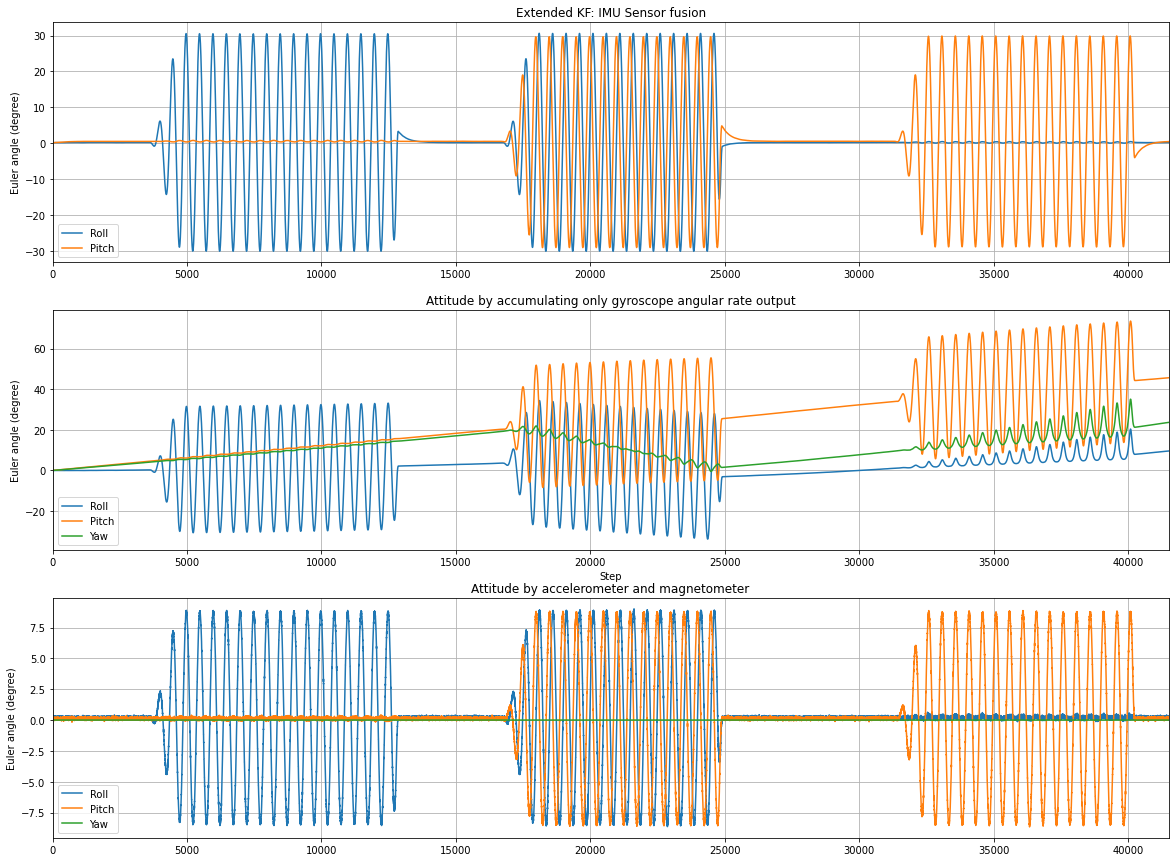

In [5]:
if measurement_update == True:
    title='Extended KF: IMU Sensor fusion'
else:
    title='Extended KF: Prediction only'

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)    
if f_number == 3:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist[:,0:2]))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)
else:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)

# Result plotting
plt.subplot(3,1,2)    
plt.plot(np.rad2deg(angle_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accumulating only gyroscope angular rate output')

# Measurement updat를 위한 accelerometer와 magnatometer의 자세
plt.subplot(3,1,3)    
plt.plot(np.rad2deg(z_hist))
#plt.plot(z_hist)
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accelerometer and magnetometer')

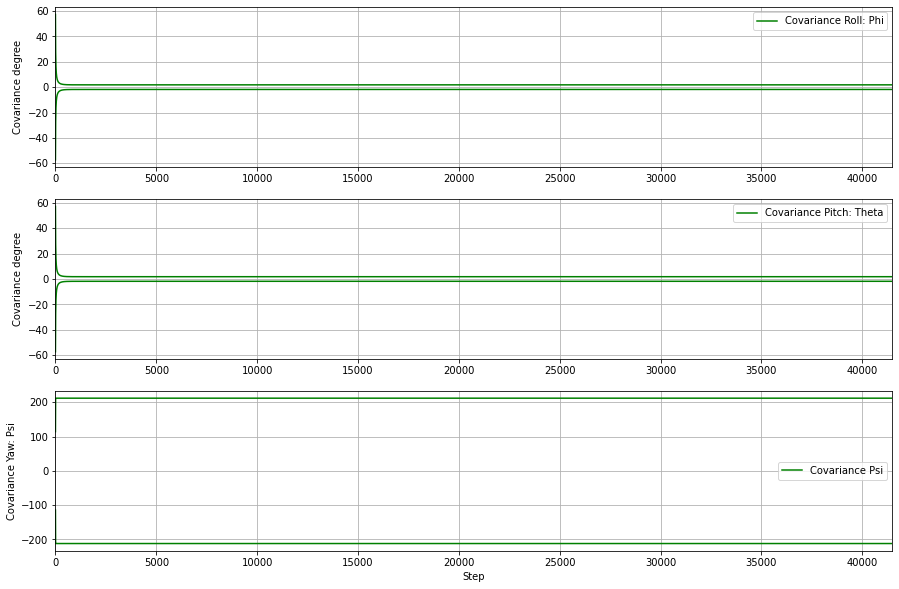

In [6]:
# Covariance plotting
# Result plotting
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(np.rad2deg(sigma_x_hist[:,0]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,0]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Roll: Phi'])

# Result plotting
plt.subplot(3,1,2)
plt.plot(np.rad2deg(sigma_x_hist[:,1]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,1]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Pitch: Theta'])

# Result plotting
plt.subplot(3,1,3)
plt.plot(np.rad2deg(sigma_x_hist[:,2]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,2]), 'g')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance Yaw: Psi')
plt.xlim([0,totalLen])
plt.legend(['Covariance Psi'])

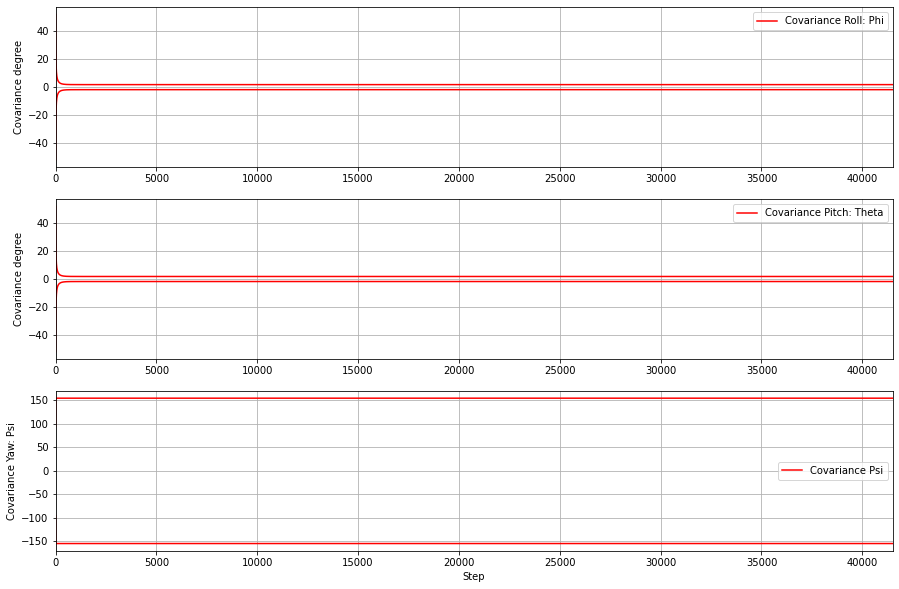

In [7]:
# Covariance plotting
# Result plotting
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(np.rad2deg(sigma_hist[:,0]), 'r')
plt.plot(-np.rad2deg(sigma_hist[:,0]), 'r')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Roll: Phi'])

# Result plotting
plt.subplot(3,1,2)
plt.plot(np.rad2deg(sigma_hist[:,1]), 'r')
plt.plot(-np.rad2deg(sigma_hist[:,1]), 'r')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Pitch: Theta'])

# Result plotting
plt.subplot(3,1,3)
plt.plot(np.rad2deg(sigma_hist[:,2]), 'r')
plt.plot(-np.rad2deg(sigma_hist[:,2]), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance Yaw: Psi')
plt.xlim([0,totalLen])
plt.legend(['Covariance Psi'])